In [1]:
import pandas as pd
import numpy as np
from gaia_download import get_masses
import matplotlib.pyplot as plt
from download_isochrone import load_isochrone
from astropy.coordinates import SkyCoord, ICRS, Galactocentric
import astropy.units as u
from simbad_download import resolve_name

In [2]:
CLUSTER_NAME: str = 'NGC 188'
ROOT_PATH: str = f'data/{CLUSTER_NAME}'

# Mass

In [3]:
clustered = pd.read_csv(f'{ROOT_PATH}/{CLUSTER_NAME}_clustered.csv')
isochrone = load_isochrone(f'{ROOT_PATH}/{CLUSTER_NAME}_isochrone.dat', with_mass=True)

In [4]:
clustered = pd.merge(clustered, get_masses(clustered.source_id), on='source_id')

In [5]:
clustered_w_mass = clustered.dropna(subset=['mass_flame'])

In [6]:
clustered_w_mass_values = clustered_w_mass[['BP-RP', 'G_abs', 'mass_flame']].values

In [7]:
clustered_w_mass_values[:, :2].shape

(817, 2)

In [8]:
isochrone.shape

(299, 3)

In [23]:
BOUNDS = np.max(isochrone[:, [0, 1]], axis=0)-np.min(isochrone[:, [0, 1]], axis=0)

In [24]:
def find_closest(x):
    return isochrone[np.argmin(np.linalg.norm((x/BOUNDS-isochrone[:, [0, 1]]/BOUNDS), axis=1).flatten())][2]

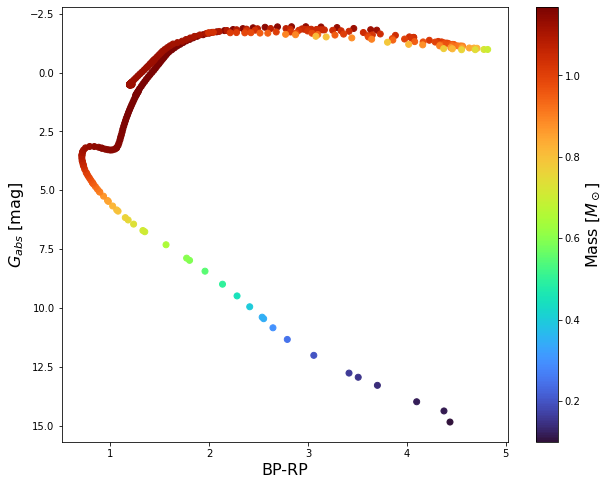

In [25]:
plt.figure(figsize=(10, 8))
plt.scatter(isochrone[:, 0], isochrone[:, 1], c=isochrone[:, 2], cmap='turbo')
cbar = plt.colorbar()
cbar.set_label('Mass [$M_\odot$]', fontsize=16)
plt.gca().invert_yaxis();
plt.gca().set_xlabel('BP-RP', fontsize=16)
plt.gca().set_ylabel('$G_{abs}$ [mag]', fontsize=16);

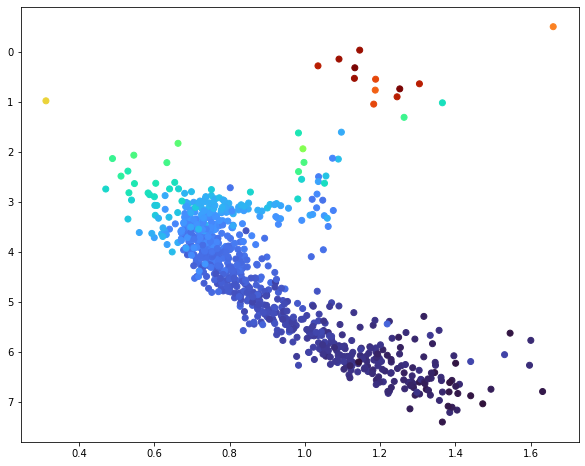

In [28]:
plt.figure(figsize=(10, 8))
plt.scatter(clustered_w_mass['BP-RP'], clustered_w_mass['G_abs'],
            c=clustered_w_mass['mass_flame'], cmap='turbo')
plt.gca().invert_yaxis();

In [33]:
clustered_without_mass = clustered[np.isnan(clustered['mass_flame'])]

In [34]:
clustered_without_mass['mass_flame'] = np.apply_along_axis(find_closest, axis=1, arr=clustered_without_mass[['BP-RP', 'G_abs']])

/tmp/ipykernel_45376/1298936366.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustered_without_mass['mass_flame'] = np.apply_along_axis(find_closest, axis=1, arr=clustered_without_mass[['BP-RP', 'G_abs']])


In [36]:
clustered = pd.concat([clustered_w_mass, clustered_without_mass])

In [38]:
clustered = clustered[clustered.mass_flame<=np.max(isochrone[:, 2])]

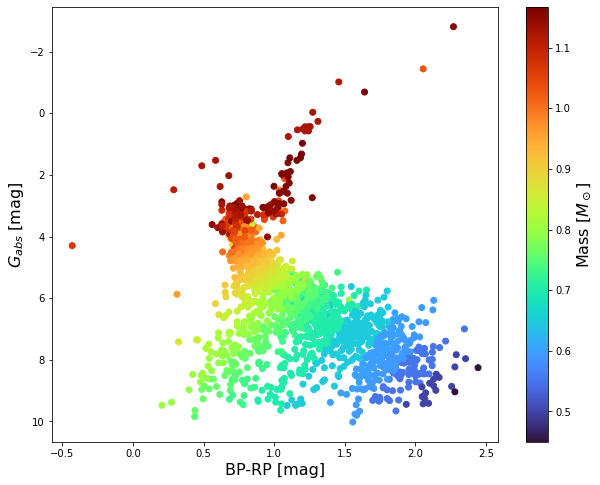

In [39]:
plt.figure(figsize=(10, 8))
plt.scatter(clustered['BP-RP'], clustered['G_abs'],
            c=clustered['mass_flame'], cmap='turbo')
plt.gca().invert_yaxis();
plt.gca().set_xlabel('BP-RP [mag]', fontsize=16)
plt.gca().set_ylabel('$G_{abs}$ [mag]', fontsize=16)
cbar = plt.colorbar()
cbar.set_label('Mass [$M_\odot$]', fontsize=16)

In [40]:
total_mass = np.sum(clustered['mass_flame']*clustered['occurences'])

In [41]:
total_mass

979.9798440065001

# Density profile

In [103]:
galactic_coords = SkyCoord(ra=clustered.ra*u.deg,
                           dec=clustered.dec*u.deg,
                           distance=1/clustered.parallax*u.kpc,
                           frame=ICRS).galactic.cartesian

In [105]:
cp_ra, cp_dec, cp_par, cp_pmra, cp_pmdec, cp_rv = resolve_name('NGC 188')

In [106]:
gc_ra, gc_dec, gc_par, _, _, _ = resolve_name('Sgr A*')

In [107]:
galactic_cp = SkyCoord(ra=cp_ra*u.deg, dec=cp_dec*u.deg,
                       distance=1/cp_par*u.kpc, frame=ICRS).galactic.cartesian

In [108]:
clustered['x'] = galactic_coords.x.value
clustered['y'] = galactic_coords.y.value
clustered['z'] = galactic_coords.z.value

In [109]:
cp_vec = np.array([galactic_cp.x.value, galactic_cp.y.value, galactic_cp.z.value])

In [110]:
SkyCoord(l=0*u.deg, b=0*u.deg, distance=8.3*u.kpc, frame='galactic').cartesian

<CartesianRepresentation (x, y, z) in kpc
    (8.3, 0., 0.)>

In [111]:
sgr_a_vec = np.array([8.3, 0., 0. ])

In [112]:
sgr_a_vec

array([8.3, 0. , 0. ])

In [113]:
unit_vector_1 = cp_vec / np.linalg.norm(cp_vec)

unit_vector_2 = sgr_a_vec/ np.linalg.norm(sgr_a_vec)

dot_product = np.dot(unit_vector_1, unit_vector_2)

angle = np.arccos(dot_product)

In [114]:
distance_from_galaxy = np.sqrt((1/cp_par)**2+8.3**2-2*(1/cp_par)*8.3*dot_product)

In [115]:
distance_from_galaxy

9.44877701429927

In [116]:
z_rad = max(galactic_coords.z)-min(galactic_coords.z)
x_rad = max(galactic_coords.x)-min(galactic_coords.x)
y_rad = max(galactic_coords.y)-min(galactic_coords.y)

In [117]:
z_rad, x_rad, y_rad

(<Quantity 1.03553579 kpc>,
 <Quantity 1.31104737 kpc>,
 <Quantity 2.01041875 kpc>)

In [118]:
radii = np.linspace(0, max(x_rad, y_rad, z_rad), 1000)
radius_mass = []

In [119]:
clustered.head()

,Unnamed: 0,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,label,occurences,mass_flame,teff_esphs,teff_espucd,teff_msc1,teff_msc2,x,y,z
3,28215,1636148068921376768,Gaia DR3 573354670612121088,573354670612121088,1494711348,2016.0,12.852203,0.035797,84.583456,0.034287,...,12,0.60,0.907794,NaN,<NA>,5453.6943,4755.9880,-0.889360,1.373102,0.651416
9,32381,1636148068921376768,Gaia DR3 573519425558811648,573519425558811648,1724536386,2016.0,10.060355,0.066832,84.526382,0.070451,...,12,0.10,0.727200,NaN,<NA>,4912.3570,4170.4053,-0.969100,1.512734,0.713506
12,32437,1636148068921376768,Gaia DR3 573521487143099392,573521487143099392,900660319,2016.0,10.125355,0.025603,84.605443,0.026345,...,12,0.35,0.936733,NaN,<NA>,5472.2705,4891.2260,-0.761714,1.188530,0.562901
18,33004,1636148068921376768,Gaia DR3 573545848194838144,573545848194838144,1131559696,2016.0,10.388068,0.041830,84.720056,0.034255,...,12,0.95,0.831593,NaN,<NA>,5580.8140,4935.1610,-0.927453,1.445379,0.688734
20,33075,1636148068921376768,Gaia DR3 573548665696104448,573548665696104448,1076129921,2016.0,9.610934,0.022340,84.824356,0.020948,...,12,0.95,1.114975,NaN,<NA>,6023.4210,5836.9263,-0.903391,1.411718,0.675817


In [123]:
def mass_for_radius(rad):
    in_sph = clustered[(clustered.x-galactic_cp.x)**2+
                        (clustered.y-galactic_cp.y)**2+
                        (clustered.z-galactic_cp.z)**2<=rad**2]
    return sum(in_sph.mass_flame*in_sph.occurences)

In [124]:
mass_for_radius(0.1)

351.6040513685004

In [125]:
for x_radius in radii:
    radius_mass.append(mass_for_radius(x_radius))

In [126]:
from scipy.optimize import fsolve

In [127]:
half_mass_radius = radii[np.argmin(np.abs(radius_mass-(total_mass/2.0)))]

In [129]:
half_mass_radius

<Quantity 0.14087018 kpc>

In [130]:
a = half_mass_radius/1.3

In [131]:
def plummer(r):
    return total_mass*(r**3/np.power(r**2+a**2, 3/2))

In [132]:
def tidal_radius(dist_gal, m):
    return dist_gal*np.power(m/(3e9), 1/3)

In [148]:
r_t = tidal_radius(distance_from_galaxy, total_mass)

In [149]:
r_c = 0.64*a.value

In [152]:
r_c

0.06935147446758293

In [159]:
def surface_density_king_profile(k, r):
    return k*((1/np.sqrt(1+np.power(r.value/r_c, 2)))-
              (1/np.sqrt(1+np.power(r_t/r_c, 2))))**2

In [167]:
k = fsolve(lambda x: np.abs(surface_density_king_profile(x, max(x_rad, y_rad, z_rad))-1), [2.])

In [168]:
k

array([2.07170165])

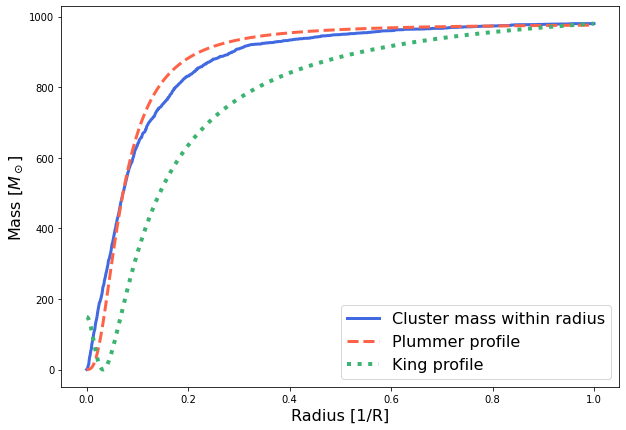

In [170]:
plt.figure(figsize=(10, 7))
plt.plot(radii/max(x_rad, y_rad, z_rad),
         radius_mass, color='royalblue', linewidth=3, label='Cluster mass within radius')
plt.plot(radii/max(x_rad, y_rad, z_rad),
         plummer(radii), color='tomato', linewidth=3, linestyle='--', label='Plummer profile')
plt.gca().set_xlabel('Radius [1/R]', fontsize=16)
plt.gca().set_ylabel('Mass [$M_\odot$]', fontsize=16)
plt.plot(radii/max(x_rad, y_rad, z_rad),
         (surface_density_king_profile(2.072, radii))*total_mass, color='mediumseagreen',
         linewidth=4, linestyle='dotted', label='King profile')

plt.legend(fontsize=16, loc='lower right')